In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [21]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [22]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [23]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

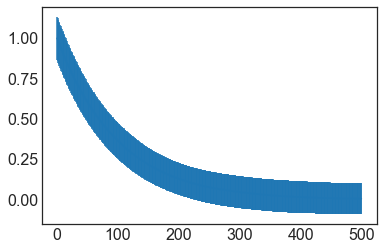

In [24]:
plt.errorbar(t,acf_mean,yerr=acf_std)

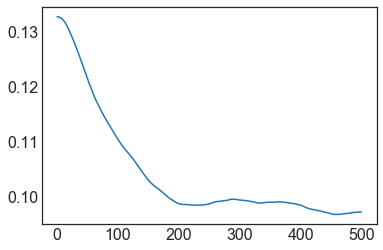

In [25]:
plt.plot(t,acf_std)

In [26]:
acf_all[0].size

500

In [27]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[0,0],
                            out.values['amplitude'],
                            out.covar[1,1],
                            out.covar[0,1]])
        print(out.fit_report(min_correl=0.25))
        
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = None
        print('fit did not work weights')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            out2.covar[0,0],
                            out2.values['amplitude'],
                            out2.covar[1,1],
                            out.covar[0,1]])
        print(out2.fit_report(min_correl=0.25))
    
    if (fit_results is None) or (fit_std_results is None):
        continue
        
    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.37953197
    reduced chi-square = 7.6211e-04
    Akaike info crit   = -3587.71227
    Bayesian info crit = -3579.28305
[[Variables]]
    decay:      99.3941866 +/- 0.96000784 (0.97%) (init = 100)
    amplitude:  0.80861570 +/- 0.00548762 (0.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 36.8918773
    reduced chi-square = 0.07408007
    Akaike info crit   = -1299.30835
    Bayesian info crit = -1290.87913
[[Variables]]
    decay:      101.268683 +/- 1.05611197 (1.04%) (init = 100)
    amplitude:  0.79842691 +/- 0.0066952

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.20215335
    reduced chi-square = 0.00241396
    Akaike info crit   = -3011.24685
    Bayesian info crit = -3002.81763
[[Variables]]
    decay:      67.8488447 +/- 1.12982406 (1.67%) (init = 100)
    amplitude:  1.00575344 +/- 0.01175631 (1.17%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 120.832157
    reduced chi-square = 0.24263485
    Akaike info crit   = -706.102826
    Bayesian info crit = -697.673609
[[Variables]]
    decay:      66.3382349 +/- 1.24777923 (1.88%) (init = 100)
    amplitude:  1.01929082 +/- 0.01512555 (1.48%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.27414567
    reduced chi-square = 0.00255853
    Akaike info crit   = -2982.16611
    Bayesian info crit = -2973.73689
[[Variables]]
    decay:      91.1122577 +/- 1.15539913 (1.27%) (init = 100)
    amplitude:  1.17667745 +/- 0.01048771 (0.89%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 129.302164
    reduced chi-square = 0.25964290
    Akaike info crit   = -672.228038
    Bayesian info crit = -663.798822
[[Variables]]
    decay:      89.5533282 +/- 1.25571612 (1.40%) (init = 100)
    amplitude:  1.18923326 +/- 0.01336982 (1.12%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.35755348
    reduced chi-square = 7.1798e-04
    Akaike info crit   = -3617.53922
    Bayesian info crit = -3609.11000
[[Variables]]
    decay:      127.863324 +/- 0.71420111 (0.56%) (init = 100)
    amplitude:  1.21045163 +/- 0.00472519 (0.39%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 36.6071861
    reduced chi-square = 0.07350841
    Akaike info crit   = -1303.18177
    Bayesian info crit = -1294.75255
[[Variables]]
    decay:      127.952298 +/- 0.77937817 (0.61%) (init = 100)
    amplitude:  1.21150327 +/- 0.00590844 (0.49%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.64326192
    reduced chi-square = 0.00329972
    Akaike info crit   = -2854.96243
    Bayesian info crit = -2846.53321
[[Variables]]
    decay:      138.071712 +/- 2.14535911 (1.55%) (init = 100)
    amplitude:  0.90412673 +/- 0.00977822 (1.08%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.709

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 143.137615
    reduced chi-square = 0.28742493
    Akaike info crit   = -621.400794
    Bayesian info crit = -612.971577
[[Variables]]
    decay:      147.534245 +/- 2.35148262 (1.59%) (init = 100)
    amplitude:  0.86225740 +/- 0.01087851 (1.26%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 102.934327
    reduced chi-square = 0.20669544
    Akaike info crit   = -786.258459
    Bayesian info crit = -777.829243
[[Variables]]
    decay:      101.349808 +/- 1.27271914 (1.26%) (init = 100)
    amplitude:  1.10715973 +/- 0.01117868 (1.01%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.722

***** Iteration  168  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.13981297
    reduced chi-square = 0.00228878
    Akaike info crit   = -3037.87196
    Bayesian info crit = -3029.44274
[[Variables]]
    decay:      107.769320 +/- 2.00902790 (1.86%) (init = 100)
    amplitude:  0.69878934 +/- 0.00914

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 40.5745637
    reduced chi-square = 0.08147503
    Akaike info crit   = -1251.73337
    Bayesian info crit = -1243.30415
[[Variables]]
    decay:      78.3657026 +/- 0.73438123 (0.94%) (init = 100)
    amplitude:  1.07550762 +/- 0.00803302 (0.75%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.714

***** Iteration  200  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.62527281
    reduced chi-square = 0.00125557
    Akaike info crit   = -3338.08767
    Bayesian info crit = -3329.65845
[[Variables]]
    decay:      83.8392434 +/- 0.84571550 (1.01%) (init = 100)
    amplitude:  1.07913736 +/- 0.00764

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.85390990
    reduced chi-square = 0.00171468
    Akaike info crit   = -3182.26884
    Bayesian info crit = -3173.83963
[[Variables]]
    decay:      90.9252590 +/- 1.17257286 (1.29%) (init = 100)
    amplitude:  0.94814052 +/- 0.00859439 (0.91%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 83.3361848
    reduced chi-square = 0.16734174
    Akaike info crit   = -891.862626
    Bayesian info crit = -883.433410
[[Variables]]
    decay:      88.7609914 +/- 1.23703457 (1.39%) (init = 100)
    amplitude:  0.96546165 +/- 0.01078324 (1.12%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.34544918
    reduced chi-square = 6.9367e-04
    Akaike info crit   = -3634.75892
    Bayesian info crit = -3626.32971
[[Variables]]
    decay:      150.531528 +/- 0.90281611 (0.60%) (init = 100)
    amplitude:  1.04007838 +/- 0.00431284 (0.41%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.712

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 28.7204114
    reduced chi-square = 0.05767151
    Akaike info crit   = -1424.50001
    Bayesian info crit = -1416.07080
[[Variables]]
    decay:      153.068608 +/- 0.90371601 (0.59%) (init = 100)
    amplitude:  1.02859086 +/- 0.00478586 (0.47%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 178.268164
    reduced chi-square = 0.35796820
    Akaike info crit   = -511.659571
    Bayesian info crit = -503.230355
[[Variables]]
    decay:      98.1716720 +/- 1.69461661 (1.73%) (init = 100)
    amplitude:  1.07828359 +/- 0.01495903 (1.39%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.721

***** Iteration  300  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 4.63883086
    reduced chi-square = 0.00931492
    Akaike info crit   = -2336.07287
    Bayesian info crit = -2327.64365
[[Variables]]
    decay:      70.7486943 +/- 2.06236246 (2.92%) (init = 100)
    amplitude:  1.10564626 +/- 0.02262

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.35056616
    reduced chi-square = 7.0395e-04
    Akaike info crit   = -3627.40697
    Bayesian info crit = -3618.97775
[[Variables]]
    decay:      147.022131 +/- 0.77948383 (0.53%) (init = 100)
    amplitude:  1.19525561 +/- 0.00439036 (0.37%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.711

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 34.3219959
    reduced chi-square = 0.06891967
    Akaike info crit   = -1335.41084
    Bayesian info crit = -1326.98162
[[Variables]]
    decay:      145.974126 +/- 0.82019882 (0.56%) (init = 100)
    amplitude:  1.20266157 +/- 0.00535487 (0.45%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.78515611
    reduced chi-square = 0.00157662
    Akaike info crit   = -3224.24041
    Bayesian info crit = -3215.81119
[[Variables]]
    decay:      116.694011 +/- 1.13078716 (0.97%) (init = 100)
    amplitude:  1.07589752 +/- 0.00730916 (0.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 79.1683969
    reduced chi-square = 0.15897268
    Akaike info crit   = -917.515454
    Bayesian info crit = -909.086238
[[Variables]]
    decay:      118.743764 +/- 1.25911998 (1.06%) (init = 100)
    amplitude:  1.06015133 +/- 0.00902820 (0.85%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.24270757
    reduced chi-square = 4.8736e-04
    Akaike info crit   = -3811.25305
    Bayesian info crit = -3802.82383
[[Variables]]
    decay:      130.223575 +/- 0.95390924 (0.73%) (init = 100)
    amplitude:  0.75466083 +/- 0.00386019 (0.51%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 20.1554939
    reduced chi-square = 0.04047288
    Akaike info crit   = -1601.56560
    Bayesian info crit = -1593.13638
[[Variables]]
    decay:      131.908501 +/- 0.95173183 (0.72%) (init = 100)
    amplitude:  0.74861600 +/- 0.00431687 (0.58%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 500
    # variables        = 2
    chi-square         = 17.5532234
    reduced chi-square = 0.03524744
    Akaike info crit   = -1670.68525
    Bayesian info crit = -1662.25603
[[Variables]]
    decay:      67.7197039 +/- 4.03991777 (5.97%) (init = 100)
    amplitude:  1.07370450 +/- 0.04496702 (4.19%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 1792.85951
    reduced chi-square = 3.60011949
    Akaike info crit   = 642.479508
    Bayesian info crit = 650.908724
[[Variables]]
    decay:      64.7532542 +/- 4.37314937 (6.75%) (init = 100)
    amplitude:  1.10913738 +/- 0.05900915 (5.32%) (init = 1)
[[Corre

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 0.34066811
    reduced chi-square = 6.8407e-04
    Akaike info crit   = -3641.72733
    Bayesian info crit = -3633.29811
[[Variables]]
    decay:      98.1517128 +/- 0.81438650 (0.83%) (init = 100)
    amplitude:  0.89714261 +/- 0.00523084 (0.58%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 33.6304815
    reduced chi-square = 0.06753109
    Akaike info crit   = -1345.58763
    Bayesian info crit = -1337.15841
[[Variables]]
    decay:      97.1173004 +/- 0.87457221 (0.90%) (init = 100)
    amplitude:  0.90301291 +/- 0.00653423 (0.72%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 52.1513688
    reduced chi-square = 0.10472162
    Akaike info crit   = -1126.22884
    Bayesian info crit = -1117.79962
[[Variables]]
    decay:      80.2007137 +/- 1.00844927 (1.26%) (init = 100)
    amplitude:  0.89671917 +/- 0.00899716 (1.00%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.714

***** Iteration  485  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.58480650
    reduced chi-square = 0.00117431
    Akaike info crit   = -3371.54117
    Bayesian info crit = -3363.11196
[[Variables]]
    decay:      131.325104 +/- 1.00071375 (0.76%) (init = 100)
    amplitude:  1.12221272 +/- 0.00596

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 344.817947
    reduced chi-square = 0.69240552
    Akaike info crit   = -181.795755
    Bayesian info crit = -173.366539
[[Variables]]
    decay:      174.618116 +/- 5.38494538 (3.08%) (init = 100)
    amplitude:  0.65441136 +/- 0.01557781 (2.38%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.751

***** Iteration  519  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.77033306
    reduced chi-square = 0.00556292
    Akaike info crit   = -2593.82027
    Bayesian info crit = -2585.39106
[[Variables]]
    decay:      70.9087042 +/- 1.53725384 (2.17%) (init = 100)
    amplitude:  1.14746874 +/- 0.01746

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 172.991240
    reduced chi-square = 0.34737197
    Akaike info crit   = -526.683570
    Bayesian info crit = -518.254354
[[Variables]]
    decay:      102.127380 +/- 1.52998191 (1.50%) (init = 100)
    amplitude:  1.19821999 +/- 0.01443391 (1.20%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.723

***** Iteration  550  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.73810892
    reduced chi-square = 0.00549821
    Akaike info crit   = -2599.67030
    Bayesian info crit = -2591.24108
[[Variables]]
    decay:      66.6986701 +/- 1.49145847 (2.24%) (init = 100)
    amplitude:  1.14004764 +/- 0.01788

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 1.64683851
    reduced chi-square = 0.00330690
    Akaike info crit   = -2853.87535
    Bayesian info crit = -2845.44614
[[Variables]]
    decay:      100.363163 +/- 1.81337932 (1.81%) (init = 100)
    amplitude:  0.89619009 +/- 0.01137795 (1.27%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 171.944270
    reduced chi-square = 0.34526962
    Akaike info crit   = -529.718844
    Bayesian info crit = -521.289628
[[Variables]]
    decay:      99.2452188 +/- 1.99115141 (2.01%) (init = 100)
    amplitude:  0.90573084 +/- 0.01460811 (1.61%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 201.198026
    reduced chi-square = 0.40401210
    Akaike info crit   = -451.159236
    Bayesian info crit = -442.730020
[[Variables]]
    decay:      68.8273780 +/- 1.54660747 (2.25%) (init = 100)
    amplitude:  1.07725798 +/- 0.01914663 (1.78%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.710

***** Iteration  612  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 1.49854506
    reduced chi-square = 0.00300913
    Akaike info crit   = -2901.05671
    Bayesian info crit = -2892.62749
[[Variables]]
    decay:      118.081341 +/- 2.24493148 (1.90%) (init = 100)
    amplitude:  0.75359375 +/- 0.01004

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.64107975
    reduced chi-square = 0.00329534
    Akaike info crit   = -2855.62685
    Bayesian info crit = -2847.19763
[[Variables]]
    decay:      136.611448 +/- 2.07795701 (1.52%) (init = 100)
    amplitude:  0.92679041 +/- 0.00981936 (1.06%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.709

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 162.721496
    reduced chi-square = 0.32674999
    Akaike info crit   = -557.283986
    Bayesian info crit = -548.854770
[[Variables]]
    decay:      142.966309 +/- 2.37038322 (1.66%) (init = 100)
    amplitude:  0.89471180 +/- 0.01178059 (1.32%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 31.0066372
    reduced chi-square = 0.06226232
    Akaike info crit   = -1386.20341
    Bayesian info crit = -1377.77419
[[Variables]]
    decay:      123.077399 +/- 0.97226121 (0.79%) (init = 100)
    amplitude:  0.87539174 +/- 0.00554679 (0.63%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.731

***** Iteration  675  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.80375888
    reduced chi-square = 0.00362201
    Akaike info crit   = -2808.36767
    Bayesian info crit = -2799.93846
[[Variables]]
    decay:      134.445345 +/- 1.42474105 (1.06%) (init = 100)
    amplitude:  1.40361212 +/- 0.01037

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 92.9742959
    reduced chi-square = 0.18669537
    Akaike info crit   = -837.142516
    Bayesian info crit = -828.713300
[[Variables]]
    decay:      67.0479970 +/- 1.25833682 (1.88%) (init = 100)
    amplitude:  0.89057453 +/- 0.01319379 (1.48%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.709

***** Iteration  708  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.39822303
    reduced chi-square = 0.00280768
    Akaike info crit   = -2935.70296
    Bayesian info crit = -2927.27375
[[Variables]]
    decay:      92.7803049 +/- 1.39014680 (1.50%) (init = 100)
    amplitude:  1.03422706 +/- 0.01088

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 3.45737001
    reduced chi-square = 0.00694251
    Akaike info crit   = -2483.04996
    Bayesian info crit = -2474.62074
[[Variables]]
    decay:      86.9735185 +/- 1.77842381 (2.04%) (init = 100)
    amplitude:  1.22976847 +/- 0.01766935 (1.44%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 335.596501
    reduced chi-square = 0.67388856
    Akaike info crit   = -195.349275
    Bayesian info crit = -186.920059
[[Variables]]
    decay:      84.0762038 +/- 1.85552126 (2.21%) (init = 100)
    amplitude:  1.26132834 +/- 0.02226625 (1.77%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.42664582
    reduced chi-square = 0.00286475
    Akaike info crit   = -2925.64099
    Bayesian info crit = -2917.21178
[[Variables]]
    decay:      76.9360368 +/- 1.22713361 (1.60%) (init = 100)
    amplitude:  1.07541936 +/- 0.01204781 (1.12%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 144.592644
    reduced chi-square = 0.29034667
    Akaike info crit   = -616.343830
    Bayesian info crit = -607.914614
[[Variables]]
    decay:      75.4085902 +/- 1.34526713 (1.78%) (init = 100)
    amplitude:  1.09051142 +/- 0.01547361 (1.42%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 156.643890
    reduced chi-square = 0.31454596
    Akaike info crit   = -576.316542
    Bayesian info crit = -567.887326
[[Variables]]
    decay:      72.3376715 +/- 1.71151627 (2.37%) (init = 100)
    amplitude:  0.87697355 +/- 0.01645889 (1.88%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.711

***** Iteration  800  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.51184306
    reduced chi-square = 0.00102780
    Akaike info crit   = -3438.17266
    Bayesian info crit = -3429.74345
[[Variables]]
    decay:      141.043121 +/- 1.30080222 (0.92%) (init = 100)
    amplitude:  0.84315990 +/- 0.00540

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.17547742
    reduced chi-square = 0.00236040
    Akaike info crit   = -3022.46686
    Bayesian info crit = -3014.03764
[[Variables]]
    decay:      181.139784 +/- 2.27953744 (1.26%) (init = 100)
    amplitude:  0.86566557 +/- 0.00735357 (0.85%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.720

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 102.381890
    reduced chi-square = 0.20558612
    Akaike info crit   = -788.949128
    Bayesian info crit = -780.519912
[[Variables]]
    decay:      190.413203 +/- 2.46204467 (1.29%) (init = 100)
    amplitude:  0.83316349 +/- 0.00816088 (0.98%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 3.86816286
    reduced chi-square = 0.00776740
    Akaike info crit   = -2426.91421
    Bayesian info crit = -2418.48499
[[Variables]]
    decay:      271.829584 +/- 4.49231681 (1.65%) (init = 100)
    amplitude:  1.15585549 +/- 0.01151007 (1.00%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.748

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 341.370817
    reduced chi-square = 0.68548357
    Akaike info crit   = -186.819386
    Bayesian info crit = -178.390170
[[Variables]]
    decay:      290.918081 +/- 5.11689706 (1.76%) (init = 100)
    amplitude:  1.10147853 +/- 0.01259370 (1.14%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.23127350
    reduced chi-square = 4.6440e-04
    Akaike info crit   = -3835.38120
    Bayesian info crit = -3826.95198
[[Variables]]
    decay:      89.2711478 +/- 0.58778277 (0.66%) (init = 100)
    amplitude:  0.97520202 +/- 0.00451261 (0.46%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 23.2460483
    reduced chi-square = 0.04667881
    Akaike info crit   = -1530.23647
    Bayesian info crit = -1521.80726
[[Variables]]
    decay:      89.4490268 +/- 0.65053996 (0.73%) (init = 100)
    amplitude:  0.97289240 +/- 0.00567217 (0.58%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 46.5333669
    reduced chi-square = 0.09344050
    Akaike info crit   = -1183.21924
    Bayesian info crit = -1174.79002
[[Variables]]
    decay:      125.347773 +/- 0.84652087 (0.68%) (init = 100)
    amplitude:  1.24374029 +/- 0.00673173 (0.54%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.731

***** Iteration  926  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 3.15918877
    reduced chi-square = 0.00634375
    Akaike info crit   = -2528.14641
    Bayesian info crit = -2519.71719
[[Variables]]
    decay:      208.993616 +/- 3.91550417 (1.87%) (init = 100)
    amplitude:  0.92839407 +/- 0.01139


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 6.11958036
    reduced chi-square = 0.01228831
    Akaike info crit   = -2197.55729
    Bayesian info crit = -2189.12807
[[Variables]]
    decay:      94.1500305 +/- 0.34246120 (0.36%) (init = 100)
    amplitude:  0.97003040 +/- 0.00283308 (0.29%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.720

***** Iteration  958  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.23960399
    reduced chi-square = 0.00248916
    Akaike info crit   = -2995.90807
    Bayesian info crit = -2987.47885
[[Variables]]
    decay:      172.681252 +/- 2.54002317 (1.47%) (init = 100)
    amplitude:  0.76979442 +/- 0.0077

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.94866666
    reduced chi-square = 0.00391299
    Akaike info crit   = -2769.73136
    Bayesian info crit = -2761.30215
[[Variables]]
    decay:      90.7270629 +/- 1.33014246 (1.47%) (init = 100)
    amplitude:  1.26142742 +/- 0.01299596 (1.03%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 193.361164
    reduced chi-square = 0.38827543
    Akaike info crit   = -471.024172
    Bayesian info crit = -462.594956
[[Variables]]
    decay:      88.4963370 +/- 1.41341985 (1.60%) (init = 100)
    amplitude:  1.28527169 +/- 0.01645206 (1.28%) (init = 1)
[[Cor

/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


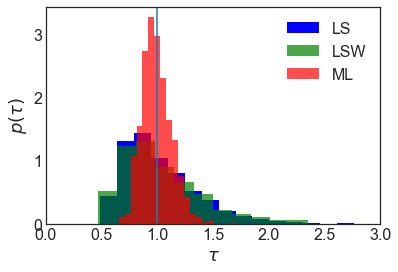

In [28]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[5],normed=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [29]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

phiW = 1/result_array.T[8]
thetaW = 1/result_array.T[6]
omegaW = 1/result_array.T[9]
dAW = np.sqrt(-theta/(phi*theta-omega**2))
dTW = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

In [30]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.051133028049292
Decay time LS std (real): 0.3905818919855628
Decay time LS stderr (real): 0.003905818919855628
Decay time (mean-true)/stderr: 13.09149991295094
Decay time LS std (fit): 0.016478751796818895
Decay time LS std (fit corrected): 0.016578702576153778
Decay time LSW mean (real): 1.0672294075424875
Decay time LSW std (real): 0.43824080319269565
Decay time LSW stderr (real): 0.004382408031926957
Decay time (mean-true)/stderr: 15.340745784670027
Decay time LSW std (fit): 0.18265766168817651
Decay time LSW std (fit corrected): 0.016578702576153778
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101


/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


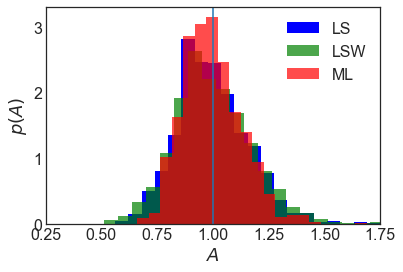

In [31]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[7],normed=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [32]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.9984105682723112
Amplitude LS std (real): 0.1618166024283861
Amplitude LS stderr (real): 0.001618166024283861
Amplitude LS std (fit): 0.011450259079258255
Amplitude LS std (fit corrected): 0.011397943753472254
Amplitude LSW mean (real): 0.9978750785778506
Amplitude LSW std (real): 0.17591566586654875
Amplitude LSW stderr (real): 0.0017591566586654874
Amplitude LSW std (fit): 0.014267847996626965
Amplitude LSW std (fit corrected): 0.011397943753472254
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702


(1000, 10)
(1000, 4)
(0.3183106738866839, 5.548446403419987e-25)


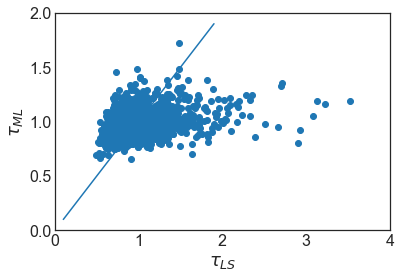

In [33]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2])
plt.plot([0.1,1.9],[0.1,1.9])
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8370114348009368, 1.3727085975446672e-263)


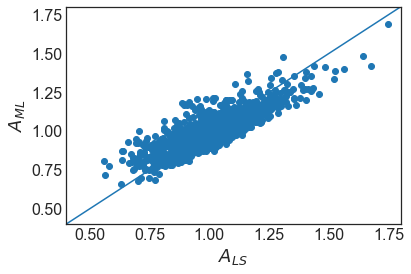

In [34]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0])
plt.plot([0,1.8],[0,1.8])
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [35]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],dA,result_array.T[0],dT):
    print(i,a,da,t,dt)

0 0.808615696067243 0.005442111581360888 0.9939418655162299 0.009520460337216735
1 0.7384507401111531 0.014800775339859715 1.659481282937803 0.04862577559506059
2 0.8189945391364237 0.008341269535271303 1.2161571141050929 0.01768900068439899
3 1.1774262133428905 0.008512380215175216 0.8696706238074898 0.008946273195651092
4 1.0437891738131544 0.014007021535994877 0.6674355511470219 0.012763371591756063
5 0.8830516169629006 0.008582190412328062 0.7431840679021235 0.010284184143841307
6 0.9986686993592873 0.005205087916664674 0.8289406604784713 0.006148559511161181
7 0.8705609102246599 0.007324202114387569 1.27617234737015 0.01536164035832357
8 1.046941596189051 0.004889410532840146 1.0666728821019373 0.0070945098580753605
9 0.8705229772045571 0.00513675618002559 1.4046446241654371 0.011921526605151563
10 1.2103311437927555 0.02160343401573561 0.6449979057204727 0.016411396205196875
11 1.0678373546171596 0.012159441207787773 1.5898917786639863 0.02633043282128308
12 1.0466327034939198 0.

515 0.9118731571232115 0.006018893434831776 0.9448365593957392 0.008874108667097017
516 0.860348247194459 0.007044693415103069 0.8392680415326923 0.0097798608123772
517 1.1500822257469152 0.010123782973655676 1.1874015040196961 0.014916144985464902
518 0.7323914577835078 0.014457609873481615 1.486286276522447 0.04238085714360774
519 1.1474687391734264 0.017225545658413152 0.7090870421501663 0.01515820819948375
520 1.100933679478445 0.010122823796299127 1.0892802731478437 0.014268567656800894
521 0.9768391743833653 0.004262137108434002 1.04800014665568 0.006510738362007299
522 1.0285984802512904 0.003612337052699844 1.3359643003352122 0.006727827836575022
523 0.7498714309582857 0.019844265362450934 0.573985126416787 0.021666076149098913
524 0.8727573767653174 0.008752214204878856 1.1678374378699485 0.01670498956921193
525 0.9873594044829184 0.008242928315668994 0.9298399317325131 0.011045353148440922
526 1.0861002234360435 0.011229420692026133 0.843540103275973 0.012409727031072366
527 

In [36]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))

0.00E+00
-79527971.81254137
0.3989422804014327
2.59E-01
-0.18841818712102068


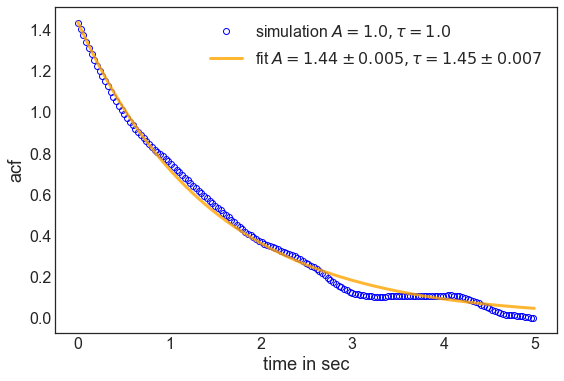

In [37]:
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="blue",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,linewidth=3,color="orange",label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [38]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']
